# Importing Libraries

In [1]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [2]:
%run "Stock Data.ipynb".ipynb
%run "Binance API.ipynb".ipynb
%run "RiskMetrics.ipynb".ipynb

# Importing Data

## Tickers

In [3]:
binance_api_key='E90xR7UnO2oeP3lrgC50zkqUuAqyyXs4uSlAGcqIVO9n90ELrFI4gfVI2HGGxxCj'
binance_api_secret='Inls2xYl9FqPi0zlIrucfxG81drx7w6Pv6SzYFxMNoAcwDjlCKug7zUM9zB3lF9h'
Binance=BinanceAPI(binance_api_key,binance_api_secret)

In [4]:
#stocks=pd.read_html('https://en.wikipedia.org/wiki/EURO_STOXX_50')[4]
#tickers=stocks['Ticker'].to_list()

## Market Data

In [5]:
start_date=datetime.datetime(2023,12,1)
enddate=start_date+datetime.timedelta(500)

In [6]:
tickers=Binance.get_market_cap()['Ticker'].iloc[:75].to_list()
holding=Binance.get_inventory()
condition=holding.index!='Total'
holding_tickers=holding.index[condition]
holding_tickers=holding_tickers.to_list()
tickers=sorted(list(set(tickers+holding_tickers)))

In [7]:
data1=Binance.get_price(tickers,start_date)
data2=Binance.get_price(tickers,enddate)
data=data1.combine_first(data2)
data.index=pd.to_datetime(data.index)
#data=data.dropna(axis=1)
n=len(data.columns)
data=data.sort_index()

In [8]:
inventory_weights=(holding['Weights in %'].apply(lambda x: np.round(x,2))).to_dict()
inventory_weights.pop('Total')

1.0

In [9]:
returns=np.log(1+data.pct_change())
returns.index=pd.to_datetime(returns.index)
with_no_na=returns.columns[np.where((returns.isna().sum()<30))]
returns_to_use=returns[with_no_na]
ex_ante_perf=returns[holding_tickers]
ex_ante_perf_to_use=ex_ante_perf.dropna()

In [10]:
weights_post=dict()

for col in ex_ante_perf.columns:
    
    if col in inventory_weights.keys():
        weights_post[col]=inventory_weights[col]
        
    else:
        weights_post[col]=0
    
current_weights=np.array(list(weights_post.values()))
current_weights=np.round(current_weights,2)/np.sum(np.round(current_weights,2))

### Positions

In [11]:
position=pd.read_excel('Positions.xlsx',index_col=0)

In [12]:
positions=Binance.get_positions_history(enddate=datetime.datetime.today()-datetime.timedelta(1),
                                        startdate=datetime.datetime(2024,5,5))
positions=positions.iloc[:-1]

2024-05-05 00:00:00
2024-06-04 00:00:00
2024-07-04 00:00:00
LDUMAUSDT not retrieved
LDUMAUSDT


In [13]:
positions=positions.sort_index()

In [14]:
positions.index=pd.to_datetime(positions.index)

In [15]:
positions=pd.concat([position,positions])
positions=positions.loc[~positions.index.duplicated(),:]

In [16]:
positions.to_excel('Positions.xlsx')

In [17]:
positions['Total']=positions.sum(axis=1)
weights_ex_post=positions.copy()
weights_ex_post=weights_ex_post.apply(lambda x: x/weights_ex_post['Total']).fillna(0)

In [18]:
binance_data=Binance.get_price(positions.columns,date=datetime.datetime(2024,5,11))
binance_data.index=pd.to_datetime(binance_data.index)
binance_data=binance_data.sort_index()

binance_data=np.log(1+binance_data.pct_change())


LDUMAUSDT not retrieved
Total not retrieved


In [19]:
historical_ptf=pd.DataFrame()

In [20]:
for col in binance_data:
    historical_ptf[col]=weights_ex_post[col]*binance_data[col]
    
historical_ptf['Historical Portfolio']=historical_ptf.sum(axis=1)

<AxesSubplot:>

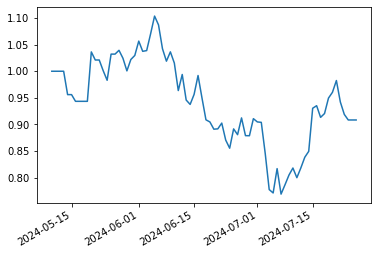

In [21]:
historical_ptf.dropna(axis = 0, how = 'all', inplace = True)
(1+historical_ptf['Historical Portfolio']).cumprod().plot()

### Ex ante data

In [22]:
ex_ante_ptf=ex_ante_perf.copy()

for key in inventory_weights.keys():
    
    ex_ante_ptf[key]=ex_ante_perf[key]*inventory_weights[key]

ex_ante_ptf=pd.DataFrame(ex_ante_ptf.sum(axis=1))

# Portfolio Optimization

In [23]:
historical_risk=RiskAnalysis(returns_to_use)
current_risk=RiskAnalysis(ex_ante_perf_to_use)
num_asset=len(returns_to_use.columns)
num_asset_current=len(ex_ante_perf_to_use.columns)

In [24]:
returns_to_use.columns

Index(['AAVEUSDT', 'ADAUSDT', 'ALGOUSDT', 'APTUSDT', 'ARBUSDT', 'ARUSDT',
       'ATOMUSDT', 'AVAXUSDT', 'AXSUSDT', 'BCHUSDT', 'BNBUSDT', 'BONKUSDT',
       'BTCUSDT', 'CFXUSDT', 'DOGEUSDT', 'DOTUSDT', 'DYDXUSDT', 'EGLDUSDT',
       'ENSUSDT', 'EOSUSDT', 'ETCUSDT', 'ETHUSDT', 'FDUSDUSDT', 'FETUSDT',
       'FILUSDT', 'FLOKIUSDT', 'FLOWUSDT', 'FTMUSDT', 'GALAUSDT', 'GRTUSDT',
       'HBARUSDT', 'ICPUSDT', 'IMXUSDT', 'INJUSDT', 'JASMYUSDT', 'LDOUSDT',
       'LINKUSDT', 'LTCUSDT', 'MATICUSDT', 'MKRUSDT', 'NEARUSDT', 'NEOUSDT',
       'OMUSDT', 'OPUSDT', 'ORDIUSDT', 'PEPEUSDT', 'QNTUSDT', 'RUNEUSDT',
       'SANDUSDT', 'SEIUSDT', 'SHIBUSDT', 'SOLUSDT', 'STXUSDT', 'SUIUSDT',
       'THETAUSDT', 'TIAUSDT', 'TRXUSDT', 'UNIUSDT', 'USDCUSDT', 'VETUSDT',
       'WBETHUSDT', 'WBTCUSDT', 'WLDUSDT', 'XLMUSDT', 'XRPUSDT', 'XTZUSDT'],
      dtype='object')

In [25]:
limit=np.where(returns_to_use.columns=='BTCUSDT')[0][0],np.where(returns_to_use.columns=='ETHUSDT')[0][0],np.where(returns_to_use.columns=='SOLUSDT')[0][0]

## Optimal Portfolio

In [26]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit[0]]-0.40}])
                                                         #  ,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                        #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
opt_weights=np.round(opt_weights,6)
inventory=historical_risk.inventory(opt_weights)
inventory

,Weights
BTCUSDT,0.400000
OMUSDT,0.375435
PEPEUSDT,0.084497
BNBUSDT,0.070276
JASMYUSDT,0.069792


In [27]:
limit=np.where(ex_ante_perf_to_use.columns=='BTCUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='ETHUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='SOLUSDT')[0][0]

In [28]:
current_optimal_weights=current_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit[0]]-0.40}])
                                                           #,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                            #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
current_optimal_weights=np.round(current_optimal_weights,6)
optimal_ptf_current=current_risk.inventory(current_optimal_weights)
optimal_ptf_current

,Weights
OMUSDT,0.489894
BTCUSDT,0.400000
JASMYUSDT,0.110106


## Real Portfolio vs Optimal

In [29]:
current_holding_comparison=holding.copy()
current_holding_comparison=current_holding_comparison.loc[current_holding_comparison.index!="Total"]
current_holding_comparison=pd.concat([current_holding_comparison,optimal_ptf_current],axis=1)
current_holding_comparison['Spread']=current_holding_comparison['Weights in %']-current_holding_comparison['Weights']
current_holding_comparison=current_holding_comparison.fillna(0)
current_holding_comparison

,Price in USDT,Weights in %,Weights,Spread
BTCUSDT,724.478185,3.326447e-01,0.400000,-0.067355
JASMYUSDT,370.482437,1.701073e-01,0.110106,0.060001
SOLUSDT,268.390977,1.232319e-01,0.000000,0.000000
OMUSDT,249.135010,1.143905e-01,0.489894,-0.375503
ETHUSDT,227.252661,1.043432e-01,0.000000,0.000000
BBUSDT,138.226032,6.346658e-02,0.000000,0.000000
MKRUSDT,119.421921,5.483266e-02,0.000000,0.000000
BNBUSDT,59.045763,2.711090e-02,0.000000,0.000000
TRXUSDT,21.501142,9.872264e-03,0.000000,0.000000
PEPEUSDT,0.000003,1.326762e-09,0.000000,0.000000


In [30]:
historical_comparison=holding.copy()
historical_comparison=historical_comparison.loc[historical_comparison.index!="Total"]
historical_comparison=pd.concat([historical_comparison,inventory],axis=1)
historical_comparison['Spread']=historical_comparison['Weights in %']-historical_comparison['Weights']
historical_comparison=historical_comparison.fillna(0)
historical_comparison

,Price in USDT,Weights in %,Weights,Spread
BTCUSDT,724.478185,3.326447e-01,0.400000,-0.067355
JASMYUSDT,370.482437,1.701073e-01,0.069792,0.100315
SOLUSDT,268.390977,1.232319e-01,0.000000,0.000000
OMUSDT,249.135010,1.143905e-01,0.375435,-0.261044
ETHUSDT,227.252661,1.043432e-01,0.000000,0.000000
BBUSDT,138.226032,6.346658e-02,0.000000,0.000000
MKRUSDT,119.421921,5.483266e-02,0.000000,0.000000
BNBUSDT,59.045763,2.711090e-02,0.070276,-0.043165
TRXUSDT,21.501142,9.872264e-03,0.000000,0.000000
PEPEUSDT,0.000003,1.326762e-09,0.084497,-0.084497


## Risk Reward Analysis

In [31]:
opt_ptf=(returns_to_use*opt_weights).sum(axis=1)
curr_opt_ptf=(ex_ante_perf*current_optimal_weights).sum(axis=1)
portfolio_perf=pd.DataFrame()
portfolio_perf['Portfolio']=(ex_ante_perf*current_weights).sum(axis=1)

In [32]:
portfolio_perf['Bitcoin']=returns['BTCUSDT']
portfolio_perf['Optimal']=opt_ptf
portfolio_perf['Current Optimal']=curr_opt_ptf

<AxesSubplot:>

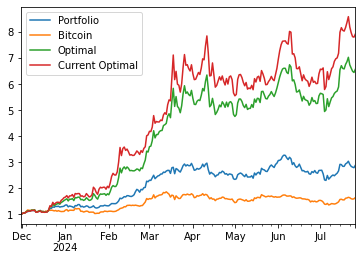

In [33]:
(1+portfolio_perf).cumprod().plot()

In [34]:
current_perf=portfolio_perf.copy()
current_perf=current_perf.loc[historical_ptf.index]
current_perf['Historical Portfolio']=historical_ptf['Historical Portfolio']

<AxesSubplot:>

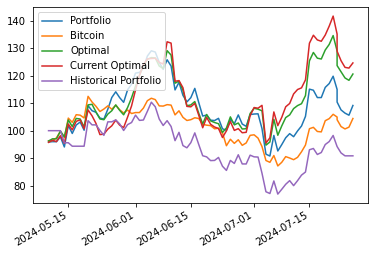

In [35]:
((1+current_perf).cumprod()*100).plot()

In [36]:
vol=historical_risk.portfolio(opt_weights).std()*np.sqrt(252)

vol

Portfolio    0.679066
dtype: float64

In [37]:
vol=current_risk.portfolio(current_weights).std()*np.sqrt(252)

vol

Portfolio    0.557187
dtype: float64

In [38]:
portfolio_perf.iloc[1:].std()*np.sqrt(252)

Portfolio          0.517043
Bitcoin            0.436335
Optimal            0.680431
Current Optimal    0.779417
dtype: float64

In [39]:
perf_analysis=pd.concat([historical_risk.perf_contrib_pct(opt_weights),historical_risk.var_contrib_pct(opt_weights)],axis=1)
perf_analysis

,Performance Contribution in %,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BNBUSDT,0.010168,0.016329,0.023589,0.002699,0.020890
BTCUSDT,0.029424,0.067405,0.177178,0.065795,0.111383
JASMYUSDT,0.018191,0.023479,0.051020,0.013824,0.037195
OMUSDT,0.905734,0.851384,0.661082,0.558379,0.102703
PEPEUSDT,0.036482,0.041403,0.087131,0.028774,0.058358


In [40]:
perf_analysis=pd.concat([current_risk.perf_contrib_pct(current_weights),current_risk.var_contrib_pct(current_weights)],axis=1)
perf_analysis

,Performance Contribution in %,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BTCUSDT,0.147247,0.314716,0.193963,0.050015,0.143948
JASMYUSDT,0.435273,0.203891,0.287476,0.117596,0.169880
SOLUSDT,0.146194,0.125208,0.126542,0.023200,0.103343
OMUSDT,0.427532,0.148881,0.124235,0.034501,0.089734
ETHUSDT,0.054939,0.096568,0.074088,0.008793,0.065295
BBUSDT,-0.177793,0.033451,0.127835,0.033964,0.093871
MKRUSDT,-0.029080,0.041713,0.044549,0.003987,0.040563
BNBUSDT,-0.010960,0.025782,0.019774,0.000630,0.019144
TRXUSDT,0.006647,0.009791,0.001537,0.000017,0.001520


## Value At Risk

### Historical

In [41]:
var,cvar=historical_risk.historical_var(opt_weights)
(var,cvar)

(-0.05602367504507088, -0.0824710806506531)

In [42]:
var,cvar=current_risk.historical_var(current_weights)
(var,cvar)

(-0.04675103085512272, -0.06772991601659006)

### Parametric

In [43]:
var,cvar=historical_risk.parametric_var(opt_weights)

(var,cvar)

(-0.07050355699847947, -0.0903660669181351)

In [44]:
var,cvar=current_risk.parametric_var(current_weights)

(var,cvar)

(-0.057733517356358545, -0.0739984068173543)

### Multivariate

In [45]:
perf=performance(historical_risk.multivariate_distribution(),opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.061905215226069024, -0.08054927392014927)

In [46]:
perf=performance(current_risk.multivariate_distribution(),current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.05430063496768113, -0.06929772511740473)

In [47]:
scenario_multivariate={}

for i in range(50):
    multivariate_distrib=pd.DataFrame(current_risk.multivariate_distribution(),columns=current_risk.returns.columns)
    multivariate_distrib=multivariate_distrib*current_weights
    multivariate_distrib=multivariate_distrib[multivariate_distrib.columns[current_weights>0]]

    multivariate_distrib['Portfolio']=multivariate_distrib.sum(axis=1)
    multivariate_var=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.05)]['Portfolio']
    results=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.05)]

    scenario_multivariate[i]=results.to_dict()

mean_scenario_multivariate=pd.DataFrame(scenario_multivariate).T.mean()
  

### Copulas

In [48]:
cop=historical_risk.gaussian_copula()
perf=performance(cop,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06469530878598241, -0.08330270664623317)

In [49]:
cop=current_risk.gaussian_copula()
perf=performance(cop,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.054045083347159045, -0.06867682710838262)

In [50]:
scenario_gaussian={}

for i in range(100):
    gaussian_copula_distrib=pd.DataFrame(current_risk.gaussian_copula(),columns=current_risk.returns.columns)

    gaussian_copula_distrib=gaussian_copula_distrib*current_weights
    gaussian_copula_distrib=gaussian_copula_distrib[gaussian_copula_distrib.columns[current_weights>0]]

    gaussian_copula_distrib['Portfolio']=gaussian_copula_distrib.sum(axis=1)
    gaussian_var=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.05)]
    
    scenario_gaussian[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_gaussian).T.mean()
mean_scenario_gaussian

BTCUSDT     -0.011203
JASMYUSDT   -0.015336
SOLUSDT     -0.007131
OMUSDT      -0.006331
ETHUSDT     -0.003937
BBUSDT      -0.007235
MKRUSDT     -0.002635
BNBUSDT     -0.001202
TRXUSDT     -0.000079
Portfolio   -0.055089
dtype: float64

In [51]:
t_copula=historical_risk.t_copula()
perf=performance(t_copula,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.0624476134174207, -0.08015223019904523)

In [52]:
t_copula=current_risk.t_copula()
perf=performance(t_copula,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.05639078210974102, -0.0707359917640542)

In [53]:
scenario_t_copula={}

for i in range(100):
    
    t_copula_distrib=pd.DataFrame(current_risk.t_copula(),columns=current_risk.returns.columns)
    t_copula_distrib=t_copula_distrib*current_weights
    t_copula_distrib=t_copula_distrib[t_copula_distrib.columns[current_weights>0]]
    t_copula_distrib['Portfolio']=t_copula_distrib.sum(axis=1)
    t_copula_var=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.05)]
    
    scenario_t_copula[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_t_copula).T.mean()
mean_scenario_gaussian

BTCUSDT     -0.010538
JASMYUSDT   -0.015625
SOLUSDT     -0.006637
OMUSDT      -0.006803
ETHUSDT     -0.003950
BBUSDT      -0.008580
MKRUSDT     -0.002529
BNBUSDT     -0.001039
TRXUSDT     -0.000082
Portfolio   -0.055783
dtype: float64

### Monte Carlo

In [54]:
spot=data[with_no_na].iloc[-1]
monte_carlo=historical_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),opt_weights)

In [55]:
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.07358713308738422, -0.09136083950546448)

In [56]:
spot=data[ex_ante_perf.columns].iloc[-1]
monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.059625309275760104, -0.0735844582820518)

In [57]:
spot=data[ex_ante_perf.columns].iloc[-1]

scenario_monte_carlo={}

for i in range(100):
    
    monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
    monte_carlo_distrib=monte_carlo[1].fillna(0)*current_weights
    monte_carlo_distrib=monte_carlo_distrib[monte_carlo_distrib.columns[current_weights>0]]
    monte_carlo_distrib['Portfolio']=monte_carlo_distrib.sum(axis=1)
    monte_carlo_var=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]['Portfolio']
    results=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]
    
    scenario_monte_carlo[i]=results
    
mean_scenario_monte_carlo=pd.DataFrame(scenario_monte_carlo).T.mean()
mean_scenario_monte_carlo

BTCUSDT     -0.010809
JASMYUSDT   -0.015720
SOLUSDT     -0.007434
OMUSDT      -0.007889
ETHUSDT     -0.004405
BBUSDT      -0.008461
MKRUSDT     -0.003024
BNBUSDT     -0.001234
TRXUSDT     -0.000098
Portfolio   -0.059073
dtype: float64

### VaR Violation

In [58]:
var_data=rolling_var(returns_to_use,opt_weights,window=30,Q=1)
var_data

,Historical,Parametric,Multivariate,Portfolio
2024-01-14,-0.058557,-0.094395,-0.082505,-0.025512
2024-01-15,-0.058557,-0.094424,-0.082473,0.017897
2024-01-16,-0.058557,-0.094843,-0.080669,0.049587
2024-01-17,-0.058557,-0.096822,-0.084634,-0.031585
2024-01-18,-0.058557,-0.098908,-0.085955,-0.034914
...,...,...,...,...
2024-07-22,-0.098997,-0.096296,-0.087187,-0.041423
2024-07-23,-0.098997,-0.095472,-0.087074,-0.018247
2024-07-24,-0.098997,-0.096112,-0.086738,-0.018470
2024-07-25,-0.098997,-0.095248,-0.089012,-0.007231


In [59]:
current_var_data=rolling_var(ex_ante_perf_to_use,current_weights,window=15,Q=1)
current_var_data

,Historical,Parametric,Multivariate,Portfolio
2024-05-28,-0.036450,-0.091832,-0.086658,-0.018767
2024-05-29,-0.028901,-0.088247,-0.078772,-0.015077
2024-05-30,-0.028901,-0.077935,-0.069556,0.041374
2024-05-31,-0.027509,-0.074212,-0.060184,0.017345
2024-06-01,-0.027509,-0.074639,-0.061273,0.034834
2024-06-02,-0.027509,-0.074871,-0.063518,0.002037
2024-06-03,-0.019500,-0.070291,-0.056062,0.013399
2024-06-04,-0.019500,-0.053442,-0.041916,0.035231
2024-06-05,-0.019500,-0.050481,-0.037590,0.015116
2024-06-06,-0.019500,-0.050238,-0.038507,-0.003544


<AxesSubplot:>

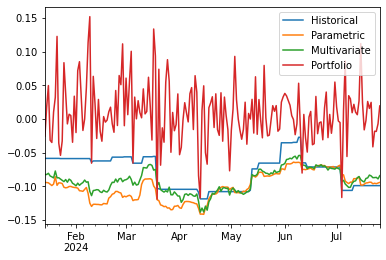

In [60]:
var_data.plot()

<AxesSubplot:>

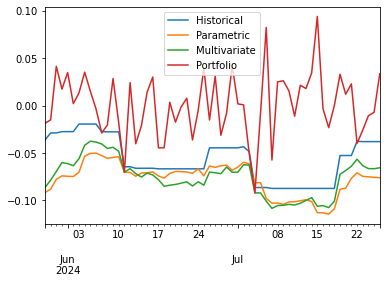

In [61]:
current_var_data.plot()

In [62]:
kupiec_test(var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.020513,0.010256,0.015385
Kupiec Stat,4.548873,9.483315,6.671087
P-value,0.03294,0.002073,0.009799


In [63]:
kupiec_test(current_var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.083333,0.016667,0.033333
Kupiec Stat,1.179267,1.872144,0.395582
P-value,0.277505,0.17123,0.52938


## Principal Component Analysis

In [64]:
eigval,eigvec,portfolio_components=historical_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.76417353, 0.07267126, 0.06145414, 0.0539017 , 0.04779938])

In [65]:
eigval,eigvec,portfolio_components_current=current_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.61591357, 0.16617654, 0.09631732, 0.07826212, 0.04333045])

In [66]:
pca_weight=dict((portfolio_components_current['PC1']/portfolio_components_current['PC1'].sum()))

<AxesSubplot:>

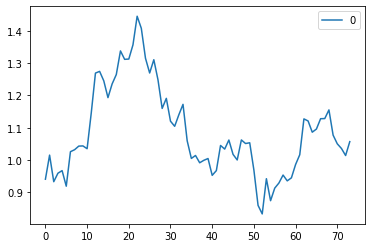

In [67]:
x=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(current_risk.returns)))
x=x.dropna()
(1+x).cumprod().plot()

<AxesSubplot:>

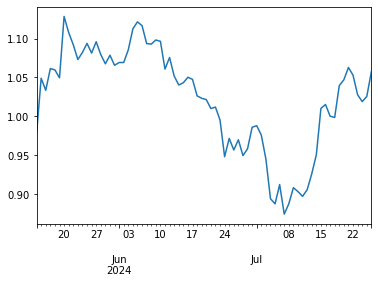

In [68]:
(1+current_risk.returns['BTCUSDT']).cumprod().plot()